In [373]:
from bs4 import BeautifulSoup
import requests
import re

import pandas as pd
import datetime
import time
from dateutil.relativedelta import *

import numpy as np
from matplotlib import pyplot as plt

In [6]:
birman = pd.read_csv("birman.csv", sep = ";", engine = "python")

In [786]:
def df_to_aegea(df_in, 
                columns = None, 
                print_index = False, 
                date_time_format = YYYY): #, start_date=None, end_date=None
    
    if (columns == None):
        columns = df_in.columns.to_list()
    
    test_df = df_in[columns]

    result = "-----\n" 
    
    if print_index:
        if test_df.index.name != None:
            result += "|**" + test_df.index.name + "** "
        else:
            result += "| "
    
    for col in columns:
        result += "| **" + col + "**"    
    
    result += "|\n|" + test_df.to_csv(sep = "|",
                        line_terminator = "|\n|",
                        index = print_index,
                        header = False,
                        date_format = date_time_format)[0:-1].replace("|", "| ") +\
             "-----"
    
    result = result.replace("\n| ", "\n|")\
                  .replace("| https:", "|https:")\
                  .replace("/| ", "/ | ")\
                  .replace("\"", "")\
                  .replace("title_with_link", "title")\
                  .replace("datetime", "date")
    
    print(result)
    

In [466]:
# DATETIME CONSTANTS

YYYY = "%Y" # 2019
YY = "%y" # 19

YYYYMM = "%Y-%m" # 2019-06 
YYYYWW = "%Y-%W" # 2019-25

DDMMYY = "%d.%m.%y" # 20.06.19


In [759]:
pd.options.display.max_colwidth = 200
pd.set_option('precision', 0)

In [145]:
print(birman.info())
birman.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4487 entries, 0 to 4486
Data columns (total 8 columns):
title       4487 non-null object
datetime    4487 non-null datetime64[ns]
views       4487 non-null int64
comments    4487 non-null int64
length      4487 non-null int64
images      4487 non-null int64
tags        4487 non-null object
link        4487 non-null object
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 280.5+ KB
None


,views,comments,length,images
count,4487.000000,4487.000000,4487.000000,4487.000000
mean,151.926677,4.874081,160.191442,0.932472
std,1534.022150,11.643250,254.291857,3.070960
min,1.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,33.000000,0.000000
50%,2.000000,0.000000,88.000000,0.000000
75%,8.000000,5.000000,185.000000,1.000000
max,87974.000000,200.000000,6026.000000,36.000000


In [37]:
branch = birman

Починить тэги, некоторые стали NaN

In [88]:
for item in branch[branch.tags.isnull()].itertuples():
    #print(item.link)
    
    blog_page = requests.get(item.link)
    blog_page_soup = BeautifulSoup(blog_page.content, "html.parser")

    string_with_tags = ""
                   
    for tag in blog_page_soup.select(".e2-tag"):
        string_with_tags += tag.get_text() + ", "

    if len(string_with_tags) > 0:
        birman.loc[item.Index, "tags"] = string_with_tags[0:-2]
    else:
        birman.loc[item.Index, "tags"] = "без тэгов"
    

Починить дату, поле стало просто объектом

In [146]:
birman = birman.astype({"datetime": "datetime64"})

birman.info()

df = birman

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4487 entries, 0 to 4486
Data columns (total 8 columns):
title       4487 non-null object
datetime    4487 non-null datetime64[ns]
views       4487 non-null int64
comments    4487 non-null int64
length      4487 non-null int64
images      4487 non-null int64
tags        4487 non-null object
link        4487 non-null object
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 280.5+ KB


Задания для разминки.

Самые-самые заметки:
- больше всего просмотров (с учетом, что просмотры с января 2018)
- больше всего комментариев
- самые длнинные заметки
- больше всего комментариев

# Просмотры

In [774]:
# make a column with Aegea-style titles with links

df["title_with_link"] = ["((" + y.link + " " + y.title + "))"
                           for y in df.itertuples()]

In [792]:
df.sort_values(by='views', ascending=False).head()

df_to_aegea(df.sort_values(by='views', ascending=False).head(),
            ["title_with_link", "datetime", "views", "tags"], 
            False)

-----
|**title**| **date**| **views**| **tags**|
|((https://ilyabirman.ru/meanwhile/2006/06/27/2/ О запятой после «С уважением»))| 2006| 87974| русский язык| 
|((https://ilyabirman.ru/meanwhile/all/pereplata/ Переплата по кредиту))| 2013| 39296| жизнь, общество, экономика| 
|((https://ilyabirman.ru/meanwhile/all/pi-and-e/ Числа π и e))| 2012| 14387| математика| 
|((https://ilyabirman.ru/meanwhile/all/war/ Война))| 2015| 13601| красная таблетка, общество| 
|((https://ilyabirman.ru/meanwhile/all/why-people-pay-taxes/ Почему люди платят налоги))| 2014| 9310| красная таблетка, общество, философия, экономика| 
-----


# Комментарии

In [793]:
df.sort_values(by='comments', ascending=False).head()

df_to_aegea(df.sort_values(by='comments', ascending=False).head(),
            ["title_with_link", "datetime", "comments", "tags"], 
            False)

-----
|**title**| **date**| **comments**| **tags**|
|((https://ilyabirman.ru/meanwhile/2009/04/28/2/ Ремонетизация ))| 2009| 200| реклама, этот сайт| 
|((https://ilyabirman.ru/meanwhile/2009/11/06/1/ Бананотехнология ))| 2009| 199| еда, жизнь| 
|((https://ilyabirman.ru/meanwhile/all/why-people-pay-taxes/ Почему люди платят налоги))| 2014| 193| красная таблетка, общество, философия, экономика| 
|((https://ilyabirman.ru/meanwhile/2010/06/04/1/ Опенсос))| 2010| 174| идиоты, опенсорс, софт| 
|((https://ilyabirman.ru/meanwhile/2007/10/08/1/ Кто на чём ))| 2007| 150| браузеры| 
-----


# Длина

In [833]:
df[[not("книги" in x) for x in df.tags]]\
                    .sort_values(by='length', ascending=False).head()

df_to_aegea(df[[not("книги" in x) for x in df.tags]]\
            .sort_values(by='length', ascending=False).head(),
            ["title_with_link", "datetime", "length", "tags"], 
            False)



-----
|**title**| **date**| **length**| **tags**|
|((https://ilyabirman.ru/meanwhile/all/berghain-guide/ Полный гид по клубу Бергхайн))| 2018| 3493| Бергхайн| 
|((https://ilyabirman.ru/meanwhile/2006/05/05/1/ SynSUN — Phoenix ))| 2006| 1714| музыка, обзоры| 
|((https://ilyabirman.ru/meanwhile/all/coffee-places/ Кофейные места))| 2017| 1657| кофе| 
|((https://ilyabirman.ru/meanwhile/all/london-underground-voice-announcements/ Голосовые объявления в лондонском метро))| 2013| 1619| голосовые объявления, лондонское метро, метро, навигация в общественных местах| 
|((https://ilyabirman.ru/meanwhile/all/hebrew-2/ Как выучить иврит — 2))| 2018| 1568| иврит| 
-----


# Картинки

In [834]:
df.sort_values(by='images', ascending=False).head()

df_to_aegea(df[[not("телеграм-канал" in x) for x in df.tags]]\
            .sort_values(by='images', ascending=False).head(),
            ["title_with_link", "datetime", "images", "tags"], 
            False)

-----
|**title**| **date**| **images**| **tags**|
|((https://ilyabirman.ru/meanwhile/all/driving-tests-process-1/ Процесс создания логотипа Драйвинг-тестов. Часть 1))| 2018| 36| портфолио, процесс| 
|((https://ilyabirman.ru/meanwhile/all/saint-petersburg-grand-maket/ Санкт-Петербург: Гранд-макет))| 2018| 29| мир, музеи и выставки, Санкт-Петербург| 
|((https://ilyabirman.ru/meanwhile/all/tel-aviv-2017-2018-florentin/ Тель-Авив: прогулка по Флорентину))| 2018| 28| мир, Тель-Авив| 
|((https://ilyabirman.ru/meanwhile/all/munich-bmw-museum/ Музей БМВ в Мюнхене))| 2016| 26| автомобиль, Германия, музеи и выставки, фото| 
|((https://ilyabirman.ru/meanwhile/all/aeroflot-registration/ Регистрация на рейс «Аэрофлота»))| 2017| 24| полёты, пользовательский интерфейс, студентам| 
-----


# Эгея и просмотры

До определённого момента Эгея не показывала просмотры. Все просмотры до этого момента не засчитались. На заметках, опубликованных раньше это фичи, просмотры считаются только с этой даты.

In [155]:
birman[birman.views == 1].sort_values(by="datetime", ascending=False).head()

,title,datetime,views,comments,length,images,tags,link
368,Аудио по четвергам: Слипархив на Твик-ФМ,2018-01-18 12:17:00,1,0,7,1,"аудио по четвергам, Слипархив, техно",https://ilyabirman.ru/meanwhile/all/sleeparchive-tweakfm/
372,Уборка улиц в Тель-Авиве,2018-01-14 18:11:00,1,1,10,1,"видео, город, из Тель-Авива, Тель-Авив",https://ilyabirman.ru/meanwhile/all/uborka-ulic-v-tel-avive/
373,Ветреный день в порту Тель-Авива,2018-01-14 17:48:00,1,0,9,1,"видео, из Тель-Авива, Тель-Авив",https://ilyabirman.ru/meanwhile/all/vetreny-den-v-portu-tel-aviva/
374,Курс о пользовательском интерфейсе и представлении информации 24—28 февраля,2018-01-14 14:54:00,1,0,105,1,курсы,https://ilyabirman.ru/meanwhile/all/ui-course-2018-feb/
383,Аудио по четвергам: «В тишине»,2018-01-04 11:04:00,1,3,58,1,"аудио по четвергам, техно",https://ilyabirman.ru/meanwhile/all/amelie-lens-in-silence/


In [132]:
birman[(birman.views == 1) & (birman.datetime.dt.strftime("%Y-%m") == "2018-01")].head(10)

,title,datetime,views,comments,length,images,tags,link
368,Аудио по четвергам: Слипархив на Твик-ФМ,2018-01-18 12:17:00,1,0,7,1,"аудио по четвергам, Слипархив, техно",https://ilyabirman.ru/meanwhile/all/sleeparchive-tweakfm/
372,Уборка улиц в Тель-Авиве,2018-01-14 18:11:00,1,1,10,1,"видео, город, из Тель-Авива, Тель-Авив",https://ilyabirman.ru/meanwhile/all/uborka-ulic-v-tel-avive/
373,Ветреный день в порту Тель-Авива,2018-01-14 17:48:00,1,0,9,1,"видео, из Тель-Авива, Тель-Авив",https://ilyabirman.ru/meanwhile/all/vetreny-den-v-portu-tel-aviva/
374,Курс о пользовательском интерфейсе и представлении информации 24—28 февраля,2018-01-14 14:54:00,1,0,105,1,курсы,https://ilyabirman.ru/meanwhile/all/ui-course-2018-feb/
383,Аудио по четвергам: «В тишине»,2018-01-04 11:04:00,1,3,58,1,"аудио по четвергам, техно",https://ilyabirman.ru/meanwhile/all/amelie-lens-in-silence/
386,Фак зонту,2018-01-04 10:32:00,1,3,23,0,жизнь,https://ilyabirman.ru/meanwhile/all/umbrella/
387,Телеграм за неделю 25—31 декабря 2017,2018-01-02 22:57:00,1,0,544,18,телеграм-канал,https://ilyabirman.ru/meanwhile/all/telegram-2018-jan-1/


In [817]:
birman[(birman.datetime.dt.strftime("%Y") >= "2011") & 
      (birman.comments > 0)]\
    .groupby(birman.datetime.dt.strftime("%Y"))["comments"].count()

birman[(birman.datetime.dt.strftime("%Y") == "2014") & 
      (birman.comments > 0)]

,title,datetime,views,comments,length,images,tags,link,title_with_link
1261,Почему люди платят налоги,2014-10-01 01:29:00,9310,193,1493,0,"красная таблетка, общество, философия, экономика",https://ilyabirman.ru/meanwhile/all/why-people-pay-taxes/,((https://ilyabirman.ru/meanwhile/all/why-people-pay-taxes/ Почему люди платят налоги))
1272,Доклады на 404фесте — 2014,2014-09-17 12:52:00,1,3,230,0,404фест,https://ilyabirman.ru/meanwhile/all/404fest-2014-talks/,((https://ilyabirman.ru/meanwhile/all/404fest-2014-talks/ Доклады на 404фесте — 2014 ))
1300,Кнопка «Подписаться на блог»,2014-08-07 01:09:00,7,23,75,0,"веб-разработка, этот сайт",https://ilyabirman.ru/meanwhile/all/knopka-podpisatsya-na-blog/,((https://ilyabirman.ru/meanwhile/all/knopka-podpisatsya-na-blog/ Кнопка «Подписаться на блог» ))
1338,Где и как захостить мой сайт?,2014-07-01 02:11:00,27,61,340,0,этот сайт,https://ilyabirman.ru/meanwhile/all/gde-i-kak-zahostit-moy-sayt/,((https://ilyabirman.ru/meanwhile/all/gde-i-kak-zahostit-moy-sayt/ Где и как захостить мой сайт? ))
1357,Дискуссии по понедельникам: национальные спортивные достижения,2014-05-26 14:41:00,3,28,163,0,"дискуссии по понедельникам, спорт",https://ilyabirman.ru/meanwhile/all/monday-discussion-national-sport/,((https://ilyabirman.ru/meanwhile/all/monday-discussion-national-sport/ Дискуссии по понедельникам: национальные спортивные достижения ))
1366,Дискуссии по понедельникам: куда валить?,2014-05-19 12:54:00,7,37,174,1,дискуссии по понедельникам,https://ilyabirman.ru/meanwhile/all/monday-discussion-departure/,((https://ilyabirman.ru/meanwhile/all/monday-discussion-departure/ Дискуссии по понедельникам: куда валить? ))
1370,Дискуссии по понедельникам: дизайнерские книги,2014-05-12 13:45:00,4,13,156,0,"дизайн, дискуссии по понедельникам, книги",https://ilyabirman.ru/meanwhile/all/monday-discussion-designers-books/,((https://ilyabirman.ru/meanwhile/all/monday-discussion-designers-books/ Дискуссии по понедельникам: дизайнерские книги ))
1371,Языки в Эгее,2014-05-11 17:17:00,1,9,219,0,"вопрос, Эгея",https://ilyabirman.ru/meanwhile/all/yazyki-v-egee/,((https://ilyabirman.ru/meanwhile/all/yazyki-v-egee/ Языки в Эгее ))
1380,Дискуссии по понедельникам: что хорошего в патриотизме?,2014-05-05 14:00:00,45,84,185,0,"дискуссии по понедельникам, общество",https://ilyabirman.ru/meanwhile/all/monday-discussion-patriotism/,((https://ilyabirman.ru/meanwhile/all/monday-discussion-patriotism/ Дискуссии по понедельникам: что хорошего в патриотизме? ))
1390,Дискуссии по понедельникам: нумерация выходов из метро,2014-04-28 15:30:00,8,31,182,0,"дискуссии по понедельникам, метро, московское метро",https://ilyabirman.ru/meanwhile/all/monday-discussion-metro-exits/,((https://ilyabirman.ru/meanwhile/all/monday-discussion-metro-exits/ Дискуссии по понедельникам: нумерация выходов из метро ))


# Статистика по годам 

In [696]:
by_years = df.groupby(df.datetime.dt.strftime(YYYY)).sum()

by_years["posts"] = df.groupby(df.datetime.dt.strftime("%Y")).views.count()
by_years["views_mean"] = df.groupby(df.datetime.dt.strftime("%Y")).views.mean()
by_years["views_median"] = df.groupby(df.datetime.dt.strftime("%Y")).views.median()

by_years["comments_mean"] = df.groupby(df.datetime.dt.strftime("%Y")).comments.mean()
by_years["comments_median"] = df.groupby(df.datetime.dt.strftime("%Y")).comments.median()

by_years["length_mean"] = df.groupby(df.datetime.dt.strftime("%Y")).length.mean()
by_years["length_median"] = df.groupby(df.datetime.dt.strftime("%Y")).length.median()

by_years.columns


Index(['views', 'comments', 'length', 'images', 'posts', 'views_mean',
       'views_median', 'comments_mean', 'comments_median', 'length_mean',
       'length_median'],
      dtype='object')

In [698]:

by_years[['posts', 'views', 'comments', 'length', 'images']]



,posts,views,comments,length,images
datetime,,,,,
2002,11,36,0,2511,7
2003,365,597,398,23826,3
2004,505,3398,1125,39507,0
2005,375,1672,995,40191,3
2006,236,102054,1351,38190,7
2007,266,2766,2355,33408,4
2008,210,6003,2676,30365,7
2009,225,17182,4617,34210,22
2010,145,10541,2849,26297,15


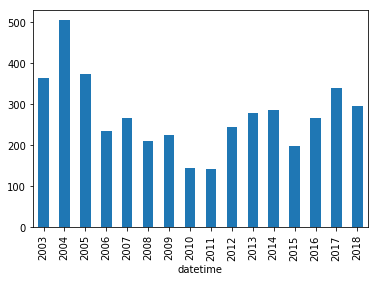

In [704]:
by_years[(by_years.index >= str(start_date.year)) &
        (by_years.index <= str(end_date.year))]["posts"].plot(kind="bar")

-----
|**datetime**| **posts**| **views**| **views_mean**| **views_median**|
| 2018| 295| 280784| 951.8101694915255| 807| 
| 2019| 93| 84838| 912.236559139785| 841| 
-----


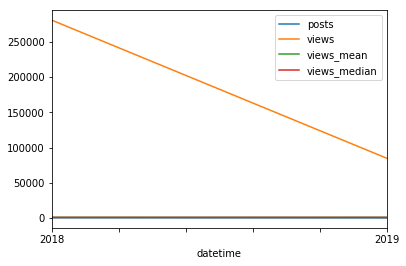

In [738]:
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

param = "views" # insert "views", "comments" or "length"
mean = param + "_mean"
median = param + "_median"

cols = ["posts", param, mean, median]

view_df = by_years[(by_years.index >= str(start_date.year)) &
                    (by_years.index <= str(end_date.year))]\
                    [cols]#.astype({"comments_mean": "int"})

# view_df.plot()

df_to_aegea(view_df, cols, True)


In [715]:
"""
by_years[(by_years.index > str(start_date.year))]\
        [["count", param, mean, median]].to_html(header = True, 
                                                decimal = ",", 
                                                float_format = '%.1f',
                                                border = 0.1,
                                                justify = "right",
                                                bold_rows = True).replace("\n","")
"""

'\nby_years[(by_years.index > str(start_date.year))]        [["count", param, mean, median]].to_html(header = True, \n                                                decimal = ",", \n                                                float_format = \'%.1f\',\n                                                border = 0.1,\n                                                justify = "right",\n                                                bold_rows = True).replace("\n","")\n\n'

In [665]:

by_years[(by_years.index > str(start_date.year))]\
        [["count", param, mean, median]].to_csv(sep = "|",
                                               float_format = '%.1f',)\
                                        .replace("|", " | ")\
                                        .replace("\n", " | ")

test_df = by_years[(by_years.index > str(start_date.year))]\
                        [["count", param, mean, median]]


df_to_aegea(by_years, ["count", param, mean, median])




-----
| **datetime**| **count**| **length**| **length_mean**| **length_median**| 
| 2002| 11| 2511| 228| 146|
| 2003| 365| 23826| 65| 44|
| 2004| 505| 39507| 78| 43|
| 2005| 375| 40191| 107| 54|
| 2006| 236| 38190| 161| 75|
| 2007| 266| 33408| 125| 67|
| 2008| 210| 30365| 144| 108|
| 2009| 225| 34210| 152| 115|
| 2010| 145| 26297| 181| 125|
| 2011| 142| 26091| 183| 152|
| 2012| 246| 43734| 177| 133|
| 2013| 280| 49875| 178| 107|
| 2014| 287| 63677| 221| 125|
| 2015| 199| 44668| 224| 118|
| 2016| 268| 54088| 201| 97|
| 2017| 339| 63107| 186| 108|
| 2018| 295| 70380| 238| 138|
| 2019| 93| 34654| 372| 132|
-----


In [598]:
"""print(export)

pattern = re.compile("<[^/]*?>")

pat1 = re.sub(pattern, "", export)

pattern2 = re.compile("<.*?>")
re.sub(pattern2, "|", pat1)"""


#sub(pattern, repl, string, count=0, flags=0)¶


'print(export)\n\npattern = re.compile("<[^/]*?>")\n\npat1 = re.sub(pattern, "", export)\n\npattern2 = re.compile("<.*?>")\nre.sub(pattern2, "|", pat1)'

# в 2012 году пропали комментарии

В 2010 году было 2849 комментариев к 145 заметкам, в 2011 комментариев было 3193. 
А вот в 2012 их стало 10

In [211]:
by_years

,views,comments,length,images,count,views_mean,views_median,comments_mean,comments_median,length_mean,length_median
datetime,,,,,,,,,,,
2002,36,0,2511,7,11,3.27,2,0.00,0.0,228.27,146.0
2003,597,398,23826,3,365,1.64,1,1.09,0.0,65.28,44.0
2004,3398,1125,39507,0,505,6.73,1,2.23,1.0,78.23,43.0
2005,1672,995,40191,3,375,4.46,1,2.65,2.0,107.18,54.0
2006,102054,1351,38190,7,236,432.43,1,5.72,3.0,161.82,75.5
2007,2766,2355,33408,4,266,10.40,1,8.85,5.5,125.59,67.0
2008,6003,2676,30365,7,210,28.59,2,12.74,9.0,144.60,108.0
2009,17182,4617,34210,22,225,76.36,3,20.52,16.0,152.04,115.0
2010,10541,2849,26297,15,145,72.70,2,19.65,14.0,181.36,125.0


Делаем зум на 2011-2012 годы и разбиваем данные по месяцам. Все 10 комментариев за 2012 год были в январе.

In [219]:
df[(df.datetime.dt.strftime("%Y") == "2011") | (df.datetime.dt.strftime("%Y") == "2012")]\
    .groupby(df.datetime.dt.strftime("%Y-%m")).sum()


,views,comments,length,images
datetime,,,,
2011-01,36,86,2154,4
2011-02,19,107,682,1
2011-03,31,334,3840,11
2011-04,158,265,2200,13
2011-05,1556,171,1133,7
2011-06,949,504,3433,20
2011-07,119,478,1848,6
2011-08,407,199,2120,7
2011-09,5529,205,1057,3


И все они были только к первой заметке в 2012 году

In [220]:
df[(df.datetime.dt.strftime("%Y-%m") == "2012-01")]


,title,datetime,views,comments,length,images,tags,link
1979,Новые правила Гугля,2012-01-31 00:12:00,4,0,285,0,"Гугль, Эпл",https://ilyabirman.ru/meanwhile/2012/01/31/1/
1980,Гетвеар,2012-01-30 13:18:00,3,0,330,1,"Бюро, Гетвеар, дизайн",https://ilyabirman.ru/meanwhile/2012/01/30/1/
1981,О поддержке Эгеи,2012-01-27 18:49:00,2,0,265,0,"вопрос, Эгея",https://ilyabirman.ru/meanwhile/2012/01/27/2/
1982,Курс по интерфейсам в Москве,2012-01-27 02:08:00,2,0,120,0,"Бюро, дизайн, курсы, пользовательский интерфейс, учёба",https://ilyabirman.ru/meanwhile/2012/01/27/1/
1983,Что почитать на выходных — 2,2012-01-22 14:11:00,2,0,201,0,"блоги, веб-дизайн, дизайн, политика, Сафари, ссылки, Хром, чтиво, Эпл",https://ilyabirman.ru/meanwhile/2012/01/22/1/
1984,Продиджи голосом,2012-01-20 18:38:00,9,0,91,1,"видео, музыка",https://ilyabirman.ru/meanwhile/2012/01/20/2/
1985,Айбукс 2 и новое образование,2012-01-20 03:56:00,1,0,128,0,"Айпад, учёба, Эпл",https://ilyabirman.ru/meanwhile/2012/01/20/1/
1986,"Апдейт Эгеи до v2546, Нисден и Фоторама",2012-01-19 22:02:00,1,0,219,0,"Нисден, Эгея",https://ilyabirman.ru/meanwhile/2012/01/19/3/
1987,Апдейт Эгеи до v2545,2012-01-19 03:48:00,2,0,255,0,"Нисден, Эгея",https://ilyabirman.ru/meanwhile/2012/01/19/2/
1988,Нужна помощь в борьбе с Адоби,2012-01-19 02:51:00,1,0,250,0,"глюки, Типографская раскладка, Фотошоп",https://ilyabirman.ru/meanwhile/all/fight-adobe/


In [222]:
df[(df.datetime.dt.strftime("%Y") == "2017") | 
   (df.datetime.dt.strftime("%Y") == "2018")]\
    .groupby(df.datetime.dt.strftime("%Y-%m")).sum()


,views,comments,length,images
datetime,,,,
2017-01,49,0,1743,23
2017-02,5289,2,3665,82
2017-03,1479,0,6382,124
2017-04,1559,0,6694,81
2017-05,109,15,3540,32
2017-06,2433,28,5221,63
2017-07,4396,0,6298,119
2017-08,414,0,2208,12
2017-09,329,0,4891,74


# В марте 2018 появился счетчик просмотров

In [226]:
df[(df.datetime.dt.strftime("%Y") == "2018")]\
    .groupby(df.datetime.dt.strftime("%Y-%U")).sum()


,views,comments,length,images
datetime,,,,
2018-00,122,17,1085,21
2018-01,112,13,624,26
2018-02,207,10,2920,56
2018-03,5947,12,2145,34
2018-04,5847,13,1930,33
2018-05,8850,23,1889,31
2018-06,10657,24,1789,22
2018-07,9002,30,1077,20
2018-08,3302,4,2381,63


# Теги




Добудем список уникальных тэгов из датафрейма и посчитаем количество заметок с этим тэгом. Результат сохраним в словаре

In [352]:
unique_tags = {}

for item in branch.itertuples():
                      
    for tag in item.tags.split(","):
        stripped_tag = tag.strip()
        
        if stripped_tag in unique_tags:
            unique_tags[stripped_tag] += 1
        else:
            unique_tags[stripped_tag] = 1


Из словаря делаем `dataframe`

In [328]:
tags_df = pd.DataFrame.from_dict(unique_tags, orient='index', columns = ["count"])
    
tags_df.sort_values(by="count", ascending = False).head()

,count
дизайн,361
видео,287
жизнь,282
музыка,253
Эгея,240


В словарь добавляем вложенный словарь с количеством заметок с данным тэгов, а также дату первой и последней заметки с этим тэгом. Разность этих дат покажет возраст тэга.

In [353]:
for key, value in unique_tags.items():

    unique_tags[key] = {"count" : value,
            "first" : df[df.tags.str.contains(key)].datetime.min().strftime("%d.%m.%y"),
            "last": df[df.tags.str.contains(key)].datetime.max().strftime("%d.%m.%y")}
    

In [458]:
tags_df_2 = pd.DataFrame.from_dict(unique_tags, orient='index')

tags_df_2 = tags_df_2.astype({"first": "datetime64",
                             "last": "datetime64"})

tags_df_2["duration"] = tags_df_2["last"] - tags_df_2["first"]

tags_df_2["relative_duration"] = [relativedelta(item.last, item.first) 
                             for item in tags_df_2.itertuples()]

tags_df_2.sort_values(by = ["duration"], ascending = False).head()

,count,first,last,duration,relative_duration
софт,57,2002-02-20,2019-09-06,6407 days,"relativedelta(years=+17, months=+6, days=+17)"
фото,154,2002-02-20,2019-05-26,6304 days,"relativedelta(years=+17, months=+3, days=+6)"
я,104,2002-07-12,2019-09-06,6265 days,"relativedelta(years=+17, months=+1, days=+25)"
жизнь,282,2002-07-12,2019-09-06,6265 days,"relativedelta(years=+17, months=+1, days=+25)"
цитаты,160,2002-02-13,2018-12-12,6146 days,"relativedelta(years=+16, months=+9, days=+29)"


Проверяем правильность полученных данных через <br>
Поиск по строке в `dataframe`: `series.str.contains()`

In [464]:
list_of_indices = df[df.tags.str.contains("(^| )цитаты($|,)", case=False)].index

len(list_of_indices)

# tweaking regex search
# df[df.tags.str.contains("(^| )софт($|,)")].tags.unique()

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


160

In [473]:
datetime.datetime(year=2019, month = 6, day = 13)

datetime.datetime(2019, 6, 13, 0, 0)

# проверить дни недели для регулярных рубрик